In [1]:
import json
from PIL import Image, ImageDraw 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder


C:\Users\DINHDUY\AppData\Local\Temp\ipykernel_11548\3614514833.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Config Directories

In [2]:
#BDD Annotation
vgRoot = 'VisualGenome/'

vgAttr = vgRoot+'Annotation/attributes.json'
vgSG = vgRoot+'Annotation/scene_graphs.json'


In [3]:
fVG = open(vgAttr)
dataAttr = json.load(fVG)
len(dataAttr)

108077

In [4]:
fVG = open(vgSG)
dataSG = json.load(fVG)
len(dataSG)

108077

In [31]:
dataItemAttr = dataAttr[701]
dataItemAttr

{'image_id': 702,
 'attributes': [{'synsets': ['sky.n.01'],
   'h': 127,
   'object_id': 1059018,
   'names': ['sky'],
   'w': 213,
   'y': 28,
   'x': 168},
  {'synsets': ['cloud.n.01'],
   'h': 144,
   'object_id': 1059017,
   'names': ['cloud'],
   'w': 169,
   'attributes': ['white', 'puffy'],
   'y': 136,
   'x': 387},
  {'synsets': ['road.n.01'],
   'h': 204,
   'object_id': 1059020,
   'names': ['road'],
   'w': 298,
   'y': 395,
   'x': 195},
  {'synsets': ['line.n.01'],
   'h': 58,
   'object_id': 1059019,
   'names': ['line'],
   'w': 55,
   'attributes': ['white', 'small'],
   'y': 455,
   'x': 172},
  {'synsets': ['sign.n.02'],
   'h': 77,
   'object_id': 1059021,
   'names': ['sign'],
   'w': 84,
   'attributes': ['hanging', 'blue'],
   'y': 316,
   'x': 387},
  {'synsets': ['grass.n.01'],
   'h': 39,
   'object_id': 1059022,
   'names': ['grass'],
   'w': 38,
   'attributes': ['green'],
   'y': 393,
   'x': 460},
  {'synsets': ['cloud.n.01'],
   'h': 157,
   'object_id': 

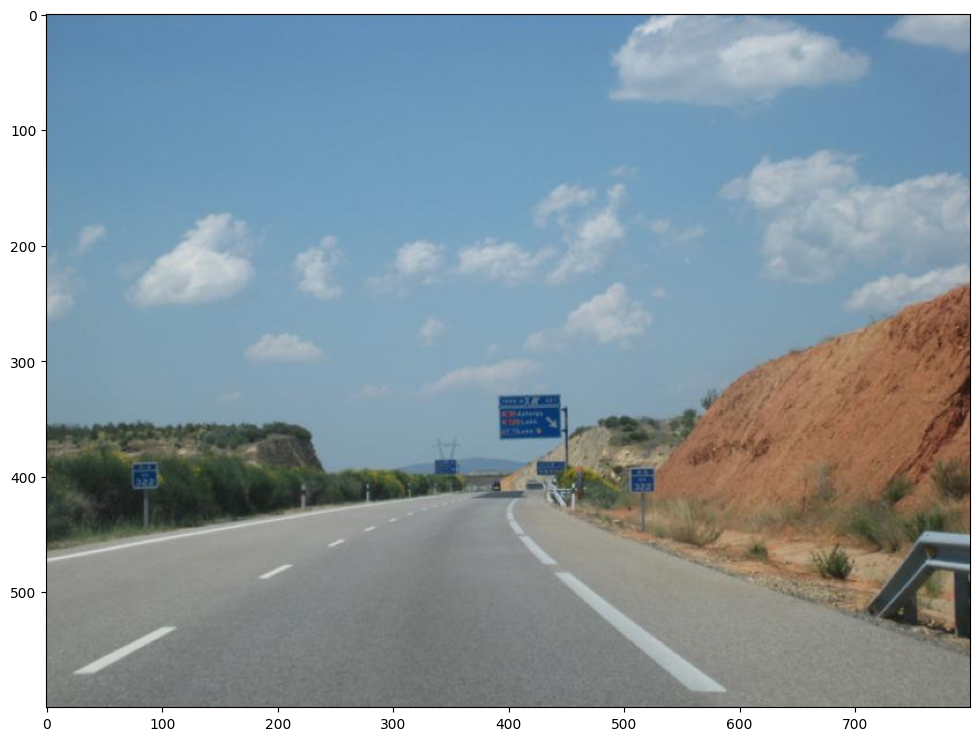

In [32]:
vgRootImage = 'VisualGenome/VG_100K/'
image = Image.open(vgRootImage+str(dataItemAttr['image_id']) + '.jpg')
plt.figure(figsize=(16,9))
plt.imshow(image)

{'object_id': 1059018, 'bbox': [168, 28, 213, 127], 'attributes': ['none']}
{'object_id': 1059017, 'bbox': [387, 136, 169, 144], 'attributes': ['white', 'puffy']}
{'object_id': 1059020, 'bbox': [195, 395, 298, 204], 'attributes': ['none']}
{'object_id': 1059019, 'bbox': [172, 455, 55, 58], 'attributes': ['white', 'small']}
{'object_id': 1059021, 'bbox': [387, 316, 84, 77], 'attributes': ['hanging', 'blue']}
{'object_id': 1059022, 'bbox': [460, 393, 38, 39], 'attributes': ['green']}
{'object_id': 3788114, 'bbox': [83, 114, 171, 157], 'attributes': ['white']}
{'object_id': 1059023, 'bbox': [373, 373, 29, 27], 'attributes': ['far']}
{'object_id': 1059024, 'bbox': [535, 407, 67, 54], 'attributes': ['green']}


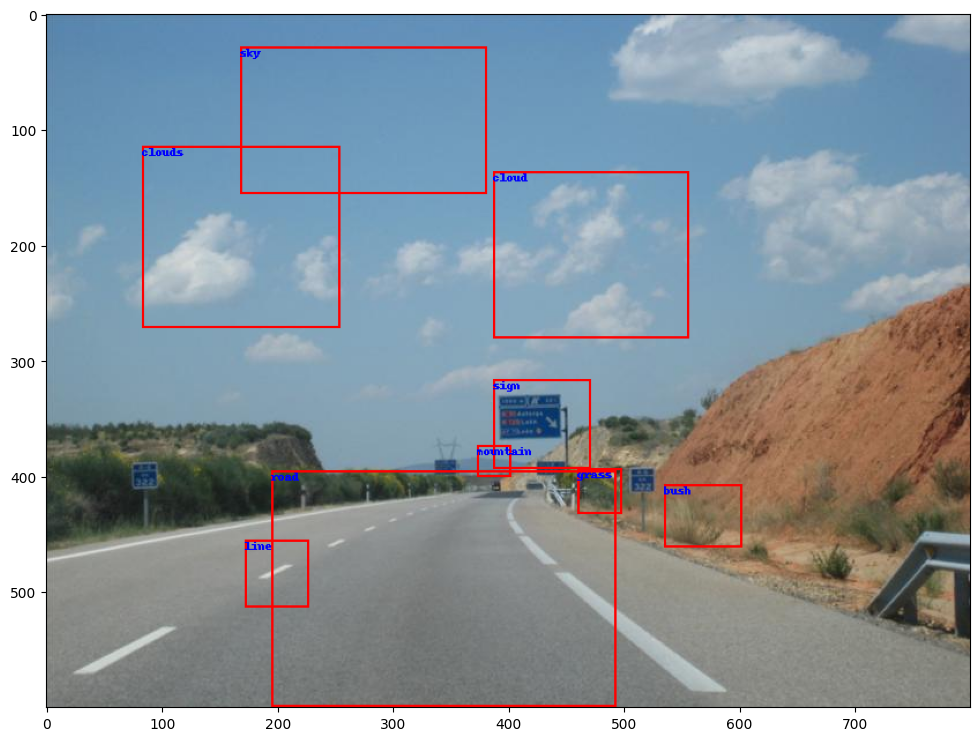

In [33]:
imCopy = image.copy()
imageDraw = ImageDraw.Draw(imCopy)
for item in dataItemAttr['attributes'][:]:
    x1, y1, x2, y2 = item['x'], item['y'], item['w'], item['h']
    #print(x1, y1, x2, y2, item['names'][0])
    t = {
        'object_id': item['object_id'], 
        #'name': object['names'][0],
        'bbox': [item['x'], item['y'], item['w'], item['h']],
        'attributes': item['attributes'] if 'attributes' in item.keys() else ['none']
    }
    print(t)
    imageDraw.rectangle([(x1, y1), (x2 + x1, y2 + y1)], outline ="red", width=2) 
    imageDraw.text((x1, y1), item['names'][0], fill='blue')
plt.figure(figsize=(16,9))
plt.imshow(imCopy)
        

In [24]:
dataItemSG = dataSG[268]
dataItemSG

{'relationships': [{'synsets': ['along.r.01'],
   'predicate': 'ON',
   'relationship_id': 3726079,
   'object_id': 1634836,
   'subject_id': 3563091},
  {'synsets': ['walk.v.01'],
   'predicate': 'walking on',
   'relationship_id': 3726080,
   'object_id': 1634837,
   'subject_id': 3563092},
  {'synsets': ['have.v.01'],
   'predicate': 'holding',
   'relationship_id': 3726081,
   'object_id': 1634839,
   'subject_id': 1634838},
  {'synsets': ['along.r.01'],
   'predicate': 'ON',
   'relationship_id': 3726082,
   'object_id': 3563093,
   'subject_id': 1634838},
  {'synsets': ['in.r.01'],
   'predicate': 'IN',
   'relationship_id': 3726083,
   'object_id': 1634840,
   'subject_id': 3563094},
  {'synsets': ['park.v.01'],
   'predicate': 'parked under',
   'relationship_id': 3726084,
   'object_id': 1634841,
   'subject_id': 3563095}],
 'image_id': 269,
 'objects': [{'synsets': ['leaf.n.01'],
   'h': 147,
   'object_id': 1634834,
   'names': ['leaves'],
   'w': 185,
   'y': 22,
   'x': 19

## Build a Module for Attribute Encoder

In [40]:
attributeEncoder = []
for image in dataAttr[:]:
    for object in image['attributes']:
        if('attributes' in object.keys()):
            for item in object['attributes']:
                attributeEncoder.append(item)

attributeEncoder = list(dict.fromkeys(attributeEncoder))
attributeEncoder.append('none')
print('number of attributes: ', len(attributeEncoder))
label_encoder = LabelEncoder()
label_encoder.fit(attributeEncoder)

number of attributes:  80259


LabelEncoder()

In [66]:
ex = ['tall', 'none']
encoded_labels = label_encoder.transform(ex)
print(encoded_labels)

[69609 50852]


In [49]:
word = 'tall'
encoded_label = label_encoder.transform([word])[0]
print(f"Mã hóa của từ '{word}': {encoded_label}")
decoded_label = label_encoder.inverse_transform([encoded_label])
print(f"Nhãn '{encoded_label}' tương ứng với từ: {decoded_label[0]}")

Mã hóa của từ 'tall': 69609
Nhãn '69609' tương ứng với từ: tall


In [63]:
type(int(label_encoder.transform(['none'])[0]))

int

In [62]:
type(0)
int

int

In [71]:
# Extract objects and IDs
objects = []

for image in dataAttr[:8000]:
    objects = []
    for object in image['attributes']:
        #object.pop('synsets')
        objects.append(
            {
                'id': object['object_id'], 
                #'name': object['names'][0],
                'bbox': [object['x'], object['y'], object['w'], object['h']],
                'attributes': [int(label_encoder.transform([item])[0]) for item in object['attributes']] if 'attributes' in object.keys() else [int(label_encoder.transform(['none'])[0])]
            }
        )
    with open(vgRoot + "ExtractAttribute/" + str(image['image_id']) + ".json", "w") as outfile:
        json.dump(objects, outfile)
    
## Convert to DataFrame
# df = pd.DataFrame(objects)
# # Save to CSV
# df.to_csv('visualgenome_objects.csv', index=False)